# LGBM을 활용한 베이스라인

In [1]:
import pandas as pd
import os
import random
import numpy as np

import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

## 1. 데이터 로딩

In [3]:
# data_dir = 'drive/MyDrive/Colab Notebooks/bootcamp/data/DKT' # 경로는 상황에 맞춰서 수정해주세요!
data_dir = '../data/'

# LOAD TRAINDATA
csv_file_path = os.path.join(data_dir, 'train_data.csv') # 데이터는 대회홈페이지에서 받아주세요 :)
train_data = pd.read_csv(csv_file_path)

# LOAD TESTDATA
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_data = pd.read_csv(test_csv_file_path)
test_data['answerCode'] = test_data['answerCode'].replace(-1, np.nan)

# # LEAVE LAST INTERACTION ONLY
# train_df = test_df[test_df['userID'] == test_df['userID'].shift(-1)]
# test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# df = pd.concat([df, train_df], ignore_index=True)

In [4]:
total = pd.read_csv('../data/total_data_hyein6.csv')
df = total[total['train'] == 1]
submission = total[total['train'] == 0]

In [71]:
total.dtypes

userID                    int64
assessmentItemID         object
testId                   object
answerCode              float64
Timestamp                object
                         ...   
item_num                  int64
item_seq                  int64
elo_assessmentItemID    float64
elo_testId              float64
elo_KnowledgeTag        float64
Length: 75, dtype: object

## 2. Feature Engineering

In [25]:
def feature_engineering(train, test):
    ## train, test data concat
    train['train'] = 1
    test['train'] = 0
    total = pd.concat([train, test], ignore_index=True)
    
    ## 유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    print('Timestamp')
    total['Timestamp'] = pd.to_datetime(total['Timestamp'])
    total.sort_values(by=['userID','Timestamp'], inplace=True)#.reset_index(drop=True)
    
    ############################## 1. Timestamp ##############################
    # 1-1. hour, month
    print('hour', 'month', 'dayofweek')
    total['hour'] = total['Timestamp'].dt.hour
    total['month'] = total['Timestamp'].dt.month
    total['dayofweek'] = total['Timestamp'].dt.dayofweek
    
    # 1-2. 기존 elapsed
    print('elapsed')    # 직전 문제 풀이 소요 시간
    diff = total.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
    diff = diff.fillna(pd.Timedelta(seconds=0))
    diff = diff['Timestamp'].apply(lambda x: x.total_seconds())
    total['elapsed'] = diff
    total['elapsed'] = total['elapsed'].apply(lambda x: x if x < 600 and x>=0 else 0)
    
    # 1-3. current elapsed
    print('current elapsed')    # 현재 문제 풀이 소요 시간
    diff = total.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().shift(-1).fillna(method='ffill') # 마지막 문제 소요시간을 직전 문제 시간으로 채움
    diff = diff['Timestamp'].apply(lambda x: x.total_seconds())
    total['current_elapsed'] = diff
    total['current_elapsed'] = total['current_elapsed'].apply(lambda x: x if x < 600 and x>=0 else np.nan)
    total['current_elapsed'] = total['current_elapsed'].fillna(method='ffill')

    # 1-4. time class
    print('time class')
    total['timeClass'] = total['elapsed']//5 + 1
    
    # 1-5. day diff
    print('day_diff')
    day_diff = total.loc[:,['userID','Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
    day_diff = day_diff['Timestamp'].apply(lambda x: x.days)
    total['day_diff'] = day_diff
    total['day_diff'] = total['day_diff'].apply(lambda x: x if x < 1 and x>=0 else 1)   # 1일 이상 간격 1일로 클립
 
    # 1-6. solved_time
    # 같은 문제 몇번째 푸는지
    print('same_item_cnt')
    total['same_item_cnt'] = total.groupby(['userID', 'assessmentItemID']).cumcount() + 1
   
    # 유저, test, same_item_cnt 구분했을 때 **이전** 문제 푸는데 걸린 시간 > shift, fillna
    print('solved_time_prior')
    diff_shift = total.loc[:, ['userID', 'testId', 'Timestamp', 'same_item_cnt']].groupby(['userID', 'testId', 'same_item_cnt']).diff()#.shift(-1)
    diff_shift = diff_shift['Timestamp'].apply(lambda x: x.total_seconds())
    total['solved_time_prior'] = diff_shift
    total['solved_time_prior'].fillna(0, inplace=True)
    total['solved_time_prior'] = total['solved_time_prior'].apply(lambda x: x if x < 600 and x>=0 else 0)
    # total['solved_time_prior'] = total.groupby(['userID', 'testId', 'same_item_cnt'])['solved_time_prior'].apply(lambda x:x.fillna(x.mean()))
    
    # 유저, test, same_item_cnt 구분했을 때 문제 푸는데 걸린 시간 > shift, fillna
    print('solved_time')
    diff_shift = total.loc[:, ['userID', 'testId', 'Timestamp', 'same_item_cnt']].groupby(['userID', 'testId', 'same_item_cnt']).diff().shift(-1)
    diff_shift = diff_shift['Timestamp'].apply(lambda x: x.total_seconds())
    total['solved_time'] = diff_shift
    total['solved_time'] = total['solved_time'].apply(lambda x: x if x < 600 and x>=0 else 0)
    total['solved_time'] = total.groupby(['userID', 'testId', 'same_item_cnt'])['solved_time'].apply(lambda x:x.fillna(x.mean()))
    
    
    ############################## 2. agg값 ##############################
    print('bigcat, smallcat')
    total['bigcat'] = total['testId'].str[2]
    total['smallcat'] = total['testId'].str[7:10]
    
    # # Bigcat_class
    # print('Bigcat_class')
    # total['Bigcat_class'] = round(total['Bigcat_avg']*10)
    
    # # 맞은 사람의 문제별 평균 풀이시간
    # total = total.set_index('assessmentItemID')
    # total['Item_mean_solved_time'] = total[total['answerCode'] == 1].groupby('assessmentItemID')['solved_time_shift'].mean()
    # total = total.reset_index(drop = False)

    ## 2-1. 유저/문제/시험지/카테고리/태그별 평균 정답률
    print('avg')
    total['user_avg'] = total.groupby('userID')['answerCode'].transform('mean')
    total['item_avg'] = total.groupby('assessmentItemID')['answerCode'].transform('mean')
    total['test_avg'] = total.groupby('testId')['answerCode'].transform('mean')
    total['bigcat_avg'] = total.groupby('bigcat')['answerCode'].transform('mean')
    total['tag_avg'] = total.groupby('KnowledgeTag')['answerCode'].transform('mean')

    ## 2-2. 유저/문제/시험지/카테고리/태그별 평균 풀이시간
    print('time_avg')
    total['user_time_avg'] = total.groupby('userID')['solved_time'].transform('mean')
    total['item_time_avg'] = total.groupby('assessmentItemID')['solved_time'].transform('mean')
    total['test_time_avg'] = total.groupby('testId')['solved_time'].transform('mean')
    total['bigcat_time_avg'] = total.groupby('bigcat')['solved_time'].transform('mean')
    total['tag_time_avg'] = total.groupby('KnowledgeTag')['solved_time'].transform('mean')
     
    ## 2-3. 유저/문제/시험지/카테고리/태그별 정답률 표준편차
    print('std')
    total['user_std'] = total.groupby('userID')['answerCode'].transform('std')
    total['item_std'] = total.groupby('assessmentItemID')['answerCode'].transform('std')
    total['test_std'] = total.groupby('testId')['answerCode'].transform('std')
    total['bigcat_std'] = total.groupby('bigcat')['answerCode'].transform('std')
    total['tag_std'] = total.groupby('KnowledgeTag')['answerCode'].transform('std')
    
    ## 2-5. 유저/문제/시험지/카테고리/태그별 누적 개수
    print('cum_cnt')
    total['user_cum_cnt'] = total.groupby('userID')['answerCode'].cumcount() + 1
    total['item_cum_cnt'] = total.groupby('assessmentItemID')['answerCode'].cumcount() + 1
    total['test_cum_cnt'] = total.groupby('testId')['answerCode'].cumcount() + 1
    total['bigcat_cum_cnt'] = total.groupby('bigcat')['answerCode'].cumcount() + 1
    total['tag_cum_cnt'] = total.groupby('KnowledgeTag')['answerCode'].cumcount() + 1
    
    ## 2-6. 유저/문제/시험지/카테고리/태그별 누적정답률
    print('cum_acc')
    total['user_cor_cum_cnt'] = total.groupby('userID')['answerCode'].cumsum()
    total['item_cor_cum_cnt'] = total.groupby('assessmentItemID')['answerCode'].cumsum()
    total['test_cor_cum_cnt'] = total.groupby('testId')['answerCode'].cumsum()
    total['bigcat_cor_cum_cnt'] = total.groupby('bigcat')['answerCode'].cumsum()
    total['tag_cor_cum_cnt'] = total.groupby('KnowledgeTag')['answerCode'].cumsum()
    
    total['user_cum_acc'] = total['user_cor_cum_cnt']/total['user_cum_cnt']
    total['item_cum_acc'] = total['item_cor_cum_cnt']/total['item_cum_cnt']
    total['test_cum_acc'] = total['test_cor_cum_cnt']/total['test_cum_cnt']
    total['bigcat_cum_acc'] = total['bigcat_cor_cum_cnt']/total['bigcat_cum_cnt']
    total['tag_cum_acc'] = total['tag_cor_cum_cnt']/total['tag_cum_cnt']
    
    ## 2-7. 유저의 시험지/카테고리/태그별 누적 정답률
    print('cum_acc per user')
    total['test_cum_cnt_per_user'] = total.groupby(['userID', 'testId'])['answerCode'].cumcount() + 1
    total['bigcat_cum_cnt_per_user'] = total.groupby(['userID', 'bigcat'])['answerCode'].cumcount() + 1
    total['tag_cum_cnt_per_user'] = total.groupby(['userID', 'KnowledgeTag'])['answerCode'].cumcount() + 1
    
    total['test_cor_cum_per_user'] = total.groupby(['userID', 'testId'])['answerCode'].cumsum()
    total['bigcat_cor_cum_per_user'] = total.groupby(['userID', 'bigcat'])['answerCode'].cumsum()
    total['tag_cor_cum_per_user'] = total.groupby(['userID', 'KnowledgeTag'])['answerCode'].cumsum()
    
    total['test_cum_acc_per_user'] = total['test_cor_cum_per_user']/total['test_cum_cnt_per_user']
    total['bigcat_cum_acc_per_user'] = total['bigcat_cor_cum_per_user']/total['bigcat_cum_cnt_per_user']
    total['tag_cum_acc_per_user'] = total['tag_cor_cum_per_user']/total['tag_cum_cnt_per_user']
    
    
    ############################## 3. current ##############################
    ## 3-1. 유저의 해당 문제지 평균 정답률/풀이시간
    print('current')
    total['user_cur_avg'] = total.groupby(['userID', 'testId', 'same_item_cnt'])['answerCode'].transform('mean')
    total['user_cur_time_avg'] = total.groupby(['userID', 'testId', 'same_item_cnt'])['solved_time'].transform('mean')
    
    print('user_rolling')
    total['user_rec_avg_rolling5'] = total.groupby('userID')['answerCode'].transform(lambda x:x.rolling(5, min_periods=1).mean())
    total['user_rec_time_avg_rolling5'] = total.groupby('userID')['solved_time'].transform(lambda x:x.rolling(5, min_periods=1).mean())

    total['user_rec_avg_rolling7'] = total.groupby('userID')['answerCode'].transform(lambda x:x.rolling(7, min_periods=1).mean())
    total['user_rec_time_avg_rolling7'] = total.groupby('userID')['solved_time'].transform(lambda x:x.rolling(7, min_periods=1).mean())
    
    total['user_rec_avg_rolling10'] = total.groupby('userID')['answerCode'].transform(lambda x:x.rolling(10, min_periods=1).mean())
    total['user_rec_time_avg_rolling10'] = total.groupby('userID')['solved_time'].transform(lambda x:x.rolling(10, min_periods=1).mean())
    
    print('item_rolling')
    total['item_rec_avg_rolling5'] = total.groupby('assessmentItemID')['answerCode'].transform(lambda x:x.rolling(5, min_periods=1).mean())
    total['item_rec_time_avg_rolling5'] = total.groupby('assessmentItemID')['solved_time'].transform(lambda x:x.rolling(5, min_periods=1).mean())

    total['item_rec_avg_rolling7'] = total.groupby('assessmentItemID')['answerCode'].transform(lambda x:x.rolling(7, min_periods=1).mean())
    total['item_rec_time_avg_rolling7'] = total.groupby('assessmentItemID')['solved_time'].transform(lambda x:x.rolling(7, min_periods=1).mean())
    
    total['item_rec_avg_rolling10'] = total.groupby('assessmentItemID')['answerCode'].transform(lambda x:x.rolling(10, min_periods=1).mean())
    total['item_rec_time_avg_rolling10'] = total.groupby('assessmentItemID')['solved_time'].transform(lambda x:x.rolling(10, min_periods=1).mean())
    
    
#     # 2-1 유저/문제별 최근 정답횟수 
#     print('retCount_correct_answer')
#     total['user_retCount_correct_answer'] = total.groupby('userID')['answerCode'].transform(lambda x:x.rolling(5, min_periods=1).sum().shift(1))
#     total['item_retCount_correct_answer'] = total.groupby('assessmentItemID')['answerCode'].transform(lambda x:x.rolling(5, min_periods=1).sum().shift(1))
    

#     # 2-1 유저/문제별 최근 정답률
#     print('retCumacc')
#     total['user_retCount'] = total.groupby('userID')['answerCode'].transform(lambda x:x.rolling(5, min_periods=1).count().shift(1))
#     total['user_retCumacc'] = total['user_retCount_correct_answer']/total['user_retCount']

#     total['item_retCount'] = total.groupby('assessmentItemID')['answerCode'].transform(lambda x:x.rolling(5, min_periods=1).count().shift(1))
#     total['item_retCumacc'] = total['item_retCount_correct_answer']/total['item_retCount']
    
    
    ############################## 4. etc ##############################
    ## 문제 번호 추가
    print('item_num')
    total['item_num'] = total['assessmentItemID'].str[7:]
    
    ## 문제 푼 순서 추가 > 상대적 순서?
    print('item_seq')
    total['item_seq'] = total.groupby(['userID', 'testId', 'same_item_cnt']).cumcount()+1


    ## train, test 나누어서 return
    train_df = total[total['train']==1]
    test_df = total[total['train']==0]
    test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]
    
    
    return train_df, test_df

In [26]:
# df, submission = feature_engineering(train_data, test_data)
# display(df)
# display(submission)

Timestamp
hour month dayofweek
elapsed
current elapsed
time class
day_diff
same_item_cnt
solved_time_prior
solved_time


/tmp/ipykernel_9120/589556473.py:66: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  total['solved_time'] = total.groupby(['userID', 'testId', 'same_item_cnt'])['solved_time'].apply(lambda x:x.fillna(x.mean()))


bigcat, smallcat
avg
time_avg
std
cum_cnt
cum_acc
cum_acc per user
current
user_rolling
item_rolling
item_num
item_seq


In [27]:
df.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'train', 'hour', 'month', 'dayofweek', 'elapsed',
       'current_elapsed', 'timeClass', 'day_diff', 'same_item_cnt',
       'solved_time_prior', 'solved_time', 'bigcat', 'smallcat', 'user_avg',
       'item_avg', 'test_avg', 'bigcat_avg', 'tag_avg', 'user_time_avg',
       'item_time_avg', 'test_time_avg', 'bigcat_time_avg', 'tag_time_avg',
       'user_std', 'item_std', 'test_std', 'bigcat_std', 'tag_std',
       'user_cum_cnt', 'item_cum_cnt', 'test_cum_cnt', 'bigcat_cum_cnt',
       'tag_cum_cnt', 'user_cor_cum_cnt', 'item_cor_cum_cnt',
       'test_cor_cum_cnt', 'bigcat_cor_cum_cnt', 'tag_cor_cum_cnt',
       'user_cum_acc', 'item_cum_acc', 'test_cum_acc', 'bigcat_cum_acc',
       'tag_cum_acc', 'test_cum_cnt_per_user', 'bigcat_cum_cnt_per_user',
       'tag_cum_cnt_per_user', 'test_cor_cum_per_user',
       'bigcat_cor_cum_per_user', 'tag_cor_cum_per_user',
       'test_cum_acc_per_us

In [68]:
df.dtypes[50:]

test_cor_cum_per_user          float64
bigcat_cor_cum_per_user        float64
tag_cor_cum_per_user           float64
test_cum_acc_per_user          float64
bigcat_cum_acc_per_user        float64
tag_cum_acc_per_user           float64
user_cur_avg                   float64
user_cur_time_avg              float64
user_rec_avg_rolling5          float64
user_rec_time_avg_rolling5     float64
user_rec_avg_rolling7          float64
user_rec_time_avg_rolling7     float64
user_rec_avg_rolling10         float64
user_rec_time_avg_rolling10    float64
item_rec_avg_rolling5          float64
item_rec_time_avg_rolling5     float64
item_rec_avg_rolling7          float64
item_rec_time_avg_rolling7     float64
item_rec_avg_rolling10         float64
item_rec_time_avg_rolling10    float64
item_num                         int64
item_seq                         int64
dtype: object

In [29]:
# feats = ['assessmentItemID', 'testId', 'bigcat', 'smallcat', 'item_num']
# for f in feats:
#     df[f] = df[f].astype('category')

## 3. Train/Test 데이터 셋 분리

In [5]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)
def custom_train_test_split(df, ratio=0.7, split=True):
    
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)
    
    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['userID'].isin(user_ids)]
    test = df[df['userID'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

In [6]:
# 유저별 분리
train, test = custom_train_test_split(df)
print(train.columns)

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'train', 'hour', 'month', 'dayofweek', 'elapsed',
       'timeClass', 'same_item_cnt', 'solved_time_prior', 'solved_time',
       'bigcat', 'smallcat', 'user_avg', 'item_avg', 'test_avg', 'bigcat_avg',
       'tag_avg', 'user_time_avg', 'item_time_avg', 'test_time_avg',
       'bigcat_time_avg', 'tag_time_avg', 'user_std', 'item_std', 'test_std',
       'bigcat_std', 'tag_std', 'user_cum_cnt', 'item_cum_cnt', 'test_cum_cnt',
       'bigcat_cum_cnt', 'tag_cum_cnt', 'user_cor_cum_cnt', 'item_cor_cum_cnt',
       'test_cor_cum_cnt', 'bigcat_cor_cum_cnt', 'tag_cor_cum_cnt',
       'user_cum_acc', 'item_cum_acc', 'test_cum_acc', 'bigcat_cum_acc',
       'tag_cum_acc', 'test_cum_cnt_per_user', 'bigcat_cum_cnt_per_user',
       'tag_cum_cnt_per_user', 'test_cor_cum_per_user',
       'bigcat_cor_cum_per_user', 'tag_cor_cum_per_user',
       'test_cum_acc_per_user', 'bigcat_cum_acc_per_user',
      

In [7]:
# 사용할 Feature 설정
# FEATS = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer', 
#          'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum', 'elapsed','Bigcat','smallcat']
# FEATS = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer', 
#          'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum', 'elapsed', 'Bigcat', 'smallcat', 'item_num', 'item_seq', 'solved_time_shift']
# FEATS = ['KnowledgeTag', 'same_item_cnt', 'user_avg', 'item_avg', 'test_avg', 'tag_avg', 'user_time_avg', 'item_time_avg',
#        'test_time_avg', 'tag_time_avg', 'user_current_avg', 'user_current_time_avg', 'hour', 'item_num', 'Bigcat','smallcat']
CATE_FEATS = [#'assessmentItemID', 'testId', 
              'KnowledgeTag', 'hour', 'month', 'dayofweek',
             'timeClass', 'bigcat', 'smallcat', 'item_num']
CONTI_FEATS = ['elapsed',
               'same_item_cnt', 'solved_time_prior', 'solved_time',
               'user_avg', 'item_avg', 'test_avg', 'bigcat_avg', 'tag_avg', 
               'user_time_avg', 'item_time_avg', 'test_time_avg', 'bigcat_time_avg', 'tag_time_avg',
               'user_std', 'item_std', 'test_std', 'bigcat_std', 'tag_std',
               'user_cum_cnt', 'item_cum_cnt', 'test_cum_cnt', 'bigcat_cum_cnt',
               'tag_cum_cnt', 'user_cor_cum_cnt', 'item_cor_cum_cnt',
               'test_cor_cum_cnt', 'bigcat_cor_cum_cnt', 'tag_cor_cum_cnt',
               'user_cum_acc', 'item_cum_acc', 'test_cum_acc', 'bigcat_cum_acc',
               'tag_cum_acc', 'test_cum_cnt_per_user', 'bigcat_cum_cnt_per_user',
               'tag_cum_cnt_per_user', 'test_cor_cum_per_user',
               'bigcat_cor_cum_per_user', 'tag_cor_cum_per_user',
               'test_cum_acc_per_user', 'bigcat_cum_acc_per_user',
               'tag_cum_acc_per_user', 'user_cur_avg', 'user_cur_time_avg',
               'user_rec_avg_rolling5', 'user_rec_time_avg_rolling5',
               'user_rec_avg_rolling7', 'user_rec_time_avg_rolling7',
               'user_rec_avg_rolling10', 'user_rec_time_avg_rolling10',
               'item_rec_avg_rolling5', 'item_rec_time_avg_rolling5',
               'item_rec_avg_rolling7', 'item_rec_time_avg_rolling7',
               'item_rec_avg_rolling10', 'item_rec_time_avg_rolling10', 
               'item_seq', 'elo_assessmentItemID', 'elo_testId', 'elo_KnowledgeTag']
FEATS = CATE_FEATS + CONTI_FEATS

In [8]:
# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_test = test['answerCode']
test = test.drop(['answerCode'], axis=1)

In [9]:
lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_test = lgb.Dataset(test[FEATS], y_test)

## 4. 훈련 및 검증

In [10]:
model = lgb.train(
    {'learning_rate': 0.001, 
      'objective': 'binary', 
      'metric': 'binary_logloss',
      'sub_feature': 0.5, 
      'num_leaves': 10, 
      'min_data': 50, 
      'max_depth': 10}, 
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    verbose_eval=100,
    num_boost_round=2000,
    early_stopping_rounds=100
)

preds = model.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

[LightGBM] [Info] Number of positive: 1039565, number of negative: 546592
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.745736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12198
[LightGBM] [Info] Number of data points in the train set: 1586157, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.655399 -> initscore=0.642855
[LightGBM] [Info] Start training from score 0.642855
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.584003	valid_1's binary_logloss: 0.690335
[200]	training's binary_logloss: 0.534373	valid_1's binary_logloss: 0.638685
[300]	training's binary_logloss: 0.492443	valid_1's binary_logloss: 0.595437
[400]	training's binary_logloss: 0.456567	valid_1's binary_logloss: 0.559116
[500]	training's binary_logloss: 0.425609	valid_1's binary_logloss: 0.527867
[600]	training's binary_logloss: 0.398363	valid_1's 

## feature selection

### 1) VIF

In [78]:
# VIF를 이용한 분석은 라이브러리에 구현되어 있지 않다
# 이럴 경우 직접 만들어 사용한다
from statsmodels.stats.outliers_influence import variance_inflation_factor

class VIF:
    def __init__(self, threshold=100):
        # 모듈 임포트
        self.threshold = threshold

    def get_support(self):
        return np.array([True if vif < self.threshold else False for vif in self.vif_])

    def fit_transform(self, X):
        # pandas DataFrame을 numpy array로 변환
        X = X.values

        # X의 VIF 계산
        self.vif_ = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

        return X[:, self.get_support()]

In [79]:
selector = VIF(threshold=100)

In [80]:
# selector.fit_transform(np.array(train, dtype=float))
selector.fit_transform(train[FEATS])

array([[2.04800000e+03, 8.00000000e+00, 1.00000000e+00, ...,
        1.83000000e+02, 1.00000000e+00, 1.83000000e+02],
       [2.04800000e+03, 8.00000000e+00, 1.00000000e+00, ...,
        4.30000000e+01, 1.00000000e+00, 4.30000000e+01],
       [2.04700000e+03, 8.00000000e+00, 1.00000000e+00, ...,
        1.04000000e+02, 1.00000000e+00, 1.04000000e+02],
       ...,
       [1.98400000e+03, 8.00000000e+00, 1.00000000e+01, ...,
        3.30000000e+01, 8.00000000e-01, 2.76000000e+01],
       [1.98400000e+03, 8.00000000e+00, 1.00000000e+01, ...,
        7.00000000e+01, 6.00000000e-01, 8.24000000e+01],
       [1.98400000e+03, 8.00000000e+00, 1.00000000e+01, ...,
        0.00000000e+00, 7.77777778e-01, 0.00000000e+00]])

In [81]:
selector.vif_

[3.713026823873294,
 2.905118244627739,
 21.34406935225857,
 3.161466712100607,
 4436.408112712492,
 35.924351167432334,
 9.50833981098937,
 73.91411173118931,
 4267.138691582779,
 943.3906009936745,
 12.53648992849247,
 2.9815792869147133,
 172.01056753322638,
 668.5888873247269,
 1824.2187590894002,
 2595.8677702033915,
 1996.549551597721,
 15.98706679101434,
 12.471462594164553,
 38.25793345220566,
 355.4337320908312,
 39.80765687623955,
 191.80355954974655,
 80.09943558890025,
 672.1960908373684,
 1518.6934087013622,
 810.0489802926161,
 99.96057137615709,
 144.38701943557422,
 224.43946096608354,
 346.117936747564,
 108.09099426238717,
 92.11795784558035,
 91.56964676608449,
 191.52419855562965,
 394.4823126325501,
 112.84838016931948,
 73.57678957084323,
 334.7938505726652,
 827.8929881908633,
 2114.445844783033,
 1151.1897296906654,
 405.0395431580841,
 52.3020665988259,
 21.56185446942638,
 27.089440534725313,
 49.24155631111389,
 21.18211600948146,
 43.055630303365184,
 39.361

In [82]:
vif = list(selector.get_support())

In [83]:
for i in range(len(FEATS)):
    if vif[i]:
        print(FEATS[i])

KnowledgeTag
hour
month
dayofweek
bigcat
smallcat
item_num
solved_time_prior
solved_time
user_time_avg
item_time_avg
test_time_avg
tag_time_avg
item_std
user_cum_cnt
user_cor_cum_cnt
item_cor_cum_cnt
user_cum_acc
bigcat_cum_cnt_per_user
tag_cum_cnt_per_user
test_cor_cum_per_user
bigcat_cor_cum_per_user
tag_cor_cum_per_user
test_cum_acc_per_user
bigcat_cum_acc_per_user
tag_cum_acc_per_user
user_cur_avg
user_cur_time_avg
user_rec_avg_rolling5
user_rec_time_avg_rolling5
user_rec_time_avg_rolling7
user_rec_avg_rolling10
user_rec_time_avg_rolling10
item_rec_avg_rolling5
item_rec_time_avg_rolling5
item_rec_time_avg_rolling7
item_rec_avg_rolling10
item_rec_time_avg_rolling10


### 2) 카이제곱(CATE)

In [104]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

selector = SelectKBest(chi2, k=6)
selector.fit_transform(train[CATE_FEATS], y_train)

array([[2.048e+03, 1.000e+00, 1.000e+00, 4.000e+00, 1.300e+01, 1.000e+00],
       [2.048e+03, 1.000e+00, 3.700e+01, 4.000e+00, 1.300e+01, 2.000e+00],
       [2.047e+03, 1.000e+00, 9.000e+00, 4.000e+00, 1.300e+01, 3.000e+00],
       ...,
       [1.984e+03, 1.000e+01, 6.000e+00, 3.000e+00, 1.970e+02, 3.000e+00],
       [1.984e+03, 1.000e+01, 1.000e+00, 3.000e+00, 1.970e+02, 4.000e+00],
       [1.984e+03, 1.000e+01, 1.000e+00, 3.000e+00, 1.970e+02, 5.000e+00]])

In [105]:
# 상호 정보량
# CATE_FEATS = ['KnowledgeTag', 'hour', 'month', 'dayofweek',
#              'timeClass', 'bigcat', 'smallcat', 'item_num']
selector.scores_

array([6.79083118e+05, 2.09044730e+02, 2.30932393e+03, 1.01165891e+03,
       1.45561705e+05, 8.37988503e+04, 1.70150587e+05, 4.95157333e+04])

In [106]:
# 선택된 feature의 정보
chilist = selector.get_support()
print(chilist)

[ True False  True False  True  True  True  True]


In [107]:
for i in range(len(CATE_FEATS)):
    if chilist[i]:
        print(CATE_FEATS[i])

KnowledgeTag
month
timeClass
bigcat
smallcat
item_num


### 3) 피어슨(CONTI)

In [118]:
# 피어슨 상관계수를 이용한 분석은 라이브러리에 구현되어 있지 않다
# 이럴 경우 직접 만들어 사용한다
class PearsonCorrelation:
    def __init__(self, threshold=0.35):
        self.threshold = threshold

    def label_encoding(self, y):
        from sklearn.preprocessing import LabelEncoder
        return LabelEncoder().fit_transform(y)

    def get_support(self):
        return np.array([True if corr >= self.threshold else False for corr in self.corr_])

    def fit_transform(self, X, y):
        # pandas DataFrame을 numpy array로 변환
        X = X.values
        y = np.array(self.label_encoding(y))

        # X의 각 feature와 y의 pearson correlation 계산
        self.corr_ = np.corrcoef(X.T, y)[-1][:-1]

        return X[:, self.get_support()]

In [119]:
# iris input(X), target(Y)
selector = PearsonCorrelation()
selector.fit_transform(train[CONTI_FEATS], y_train)

array([[0.8       , 1.        , 1.        , ..., 0.96220669, 0.90667715,
        0.89091371],
       [0.62      , 1.        , 2.        , ..., 0.91425461, 0.90667715,
        0.89091371],
       [0.79333333, 1.        , 3.        , ..., 0.97054586, 0.90667715,
        0.88513617],
       ...,
       [0.89333333, 0.89333333, 1.        , ..., 0.71817234, 0.47575268,
        0.48122892],
       [0.83666667, 0.83666667, 1.        , ..., 0.56914475, 0.47575268,
        0.48122892],
       [0.57575758, 0.57      , 1.        , ..., 0.28987663, 0.47575268,
        0.48122892]])

In [120]:
# 피어슨 상관계수
selector.corr_

array([ 6.06691020e-02,  5.74702057e-04,  5.41439764e-02,  1.31418999e-01,
        3.11905749e-01,  4.16375653e-01,  3.06086433e-01,  2.24600787e-01,
        2.92763920e-01,  1.58151996e-01,  5.34921155e-02, -5.41241631e-02,
        1.44298856e-01, -4.64594258e-02, -2.28135565e-01, -3.15650055e-01,
       -2.66863588e-01, -2.08143755e-01, -2.57166366e-01,  1.22865072e-02,
       -5.97336941e-02, -1.08618840e-01, -2.32886580e-02,  1.57920774e-02,
        8.14943426e-02,  1.29671118e-01, -2.63959334e-03,  2.95971372e-02,
        7.77056245e-02,  3.33609756e-01,  4.34231200e-01,  3.13104104e-01,
        2.26846170e-01,  2.97612683e-01, -1.54566348e-01,  2.80251342e-02,
       -1.55216551e-02,  3.53854704e-01,  1.42630674e-01,  2.79708281e-01,
        7.64596359e-01,  4.77516856e-01,  7.63817900e-01,  6.57060645e-01,
        1.55953417e-01,  6.28736838e-01,  1.27305519e-01,  5.74258193e-01,
        1.33314060e-01,  5.21890802e-01,  1.33180707e-01,  5.84947566e-01,
        7.57874339e-02,  

In [121]:
# 선택된 feature의 정보
plist = selector.get_support()

In [122]:
print(plist)
for i in range(len(CONTI_FEATS)):
    if plist[i]:
        print(CONTI_FEATS[i])

[False False False False False  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True False False False False False
 False  True False False  True  True  True  True False  True False  True
 False  True False  True False  True False  True False False  True  True
  True]
item_avg
item_cum_acc
test_cor_cum_per_user
test_cum_acc_per_user
bigcat_cum_acc_per_user
tag_cum_acc_per_user
user_cur_avg
user_rec_avg_rolling5
user_rec_avg_rolling7
user_rec_avg_rolling10
item_rec_avg_rolling5
item_rec_avg_rolling7
item_rec_avg_rolling10
elo_assessmentItemID
elo_testId
elo_KnowledgeTag


### 4) backward elimination

In [45]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)

# selector = SequentialFeatureSelector(knn, n_features_to_select=2, direction='backward')
selector = SequentialFeatureSelector(knn, direction='backward')

In [128]:
selector.fit_transform(train[FEATS], y_train)

In [ ]:
# 선택된 feature의 정보
selector.get_support()

## 5. Inference

In [ ]:
# # LOAD TESTDATA
# test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
# test_df = pd.read_csv(test_csv_file_path)

# # FEATURE ENGINEERING
# test_df = feature_engineering(test_df)

# # LEAVE LAST INTERACTION ONLY
# test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# submission = submission[FEATS]
submission.head(10)


# # DROP ANSWERCODE
# test_df = test_df.drop(['answerCode'], axis=1)

,assessmentItemID,userID,testId,answerCode,Timestamp,KnowledgeTag,train,same_item_cnt,solved_time_shift,user_avg,...,test_std,tag_std,user_current_avg,user_current_time_avg,hour,month,item_num,item_seq,Bigcat,smallcat
2989,A050133008,3,A050000133,NaN,2020-10-26 13:13:57,5289,0,1,NaN,0.692754,...,0.475380,0.496517,0.857143,45.142857,13,10,008,8,5,133
3660,A070146008,4,A070000146,NaN,2020-12-27 02:47:54,9080,0,1,NaN,0.694030,...,0.476573,0.497938,0.857143,24.571429,2,12,008,8,7,146
10860,A070111008,13,A070000111,NaN,2020-12-27 04:35:09,9660,0,1,NaN,0.695289,...,0.498249,0.500051,0.428571,14.857143,4,12,008,8,7,111
15278,A090064006,17,A090000064,NaN,2020-10-30 05:48:37,2611,0,1,NaN,0.818904,...,0.497463,0.493738,1.000000,76.000000,5,10,006,6,9,064
23531,A060135007,26,A060000135,NaN,2020-10-23 11:44:18,1422,0,1,NaN,0.759067,...,0.480030,0.487891,0.666667,45.833333,11,10,007,7,6,135
26895,A020190005,29,A020000190,NaN,2020-10-22 04:38:45,8097,0,1,NaN,0.847597,...,0.438876,0.453456,1.000000,26.000000,4,10,005,5,2,190
39887,A040136005,45,A040000136,NaN,2020-10-23 08:24:19,2107,0,1,NaN,0.688827,...,0.448255,0.457104,0.250000,25.000000,8,10,005,5,4,136
47628,A040140005,53,A040000140,NaN,2020-10-26 09:13:20,2110,0,1,NaN,0.523121,...,0.452402,0.452832,0.500000,10.250000,9,10,005,5,4,140
51927,A070159007,58,A070000159,NaN,2020-12-24 21:09:29,9122,0,1,NaN,0.364198,...,0.499640,0.482075,0.142857,1.857143,21,12,007,8,7,159
57352,A070146008,64,A070000146,NaN,2020-12-29 04:30:22,9080,0,1,NaN,0.833727,...,0.476573,0.497938,1.000000,1.714286,4,12,008,8,7,146


In [129]:
# MAKE PREDICTION
total_preds = model.predict(submission[FEATS])
total_preds[:10]

array([0.95284684, 0.95173299, 0.1091563 , 0.10801688, 0.1077507 ,
       0.10735246, 0.10612258, 0.08919797, 0.08919797, 0.08919797])

In [ ]:
# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "lgbm_cet_submission.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : output/lgbm_cet_submission.csv


###**콘텐츠 라이선스**

<font color='red'><b>**WARNING**</b></font> : **본 교육 콘텐츠의 지식재산권은 재단법인 네이버커넥트에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다.** 다만, 비영리적 교육 및 연구활동에 한정되어 사용할 수 있으나 재단의 허락을 받아야 합니다. 이를 위반하는 경우, 관련 법률에 따라 책임을 질 수 있습니다.



In [134]:
lgb.plot_importance(model, max_num_features=len(FEATS), importance_type='split')

ImportError: You must install matplotlib to plot importance.

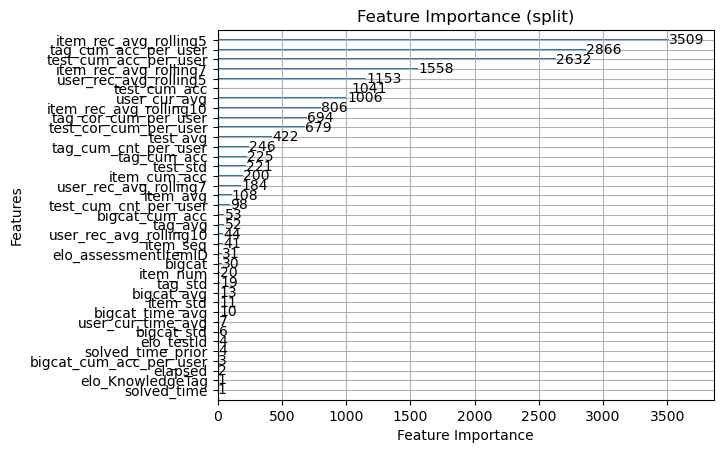

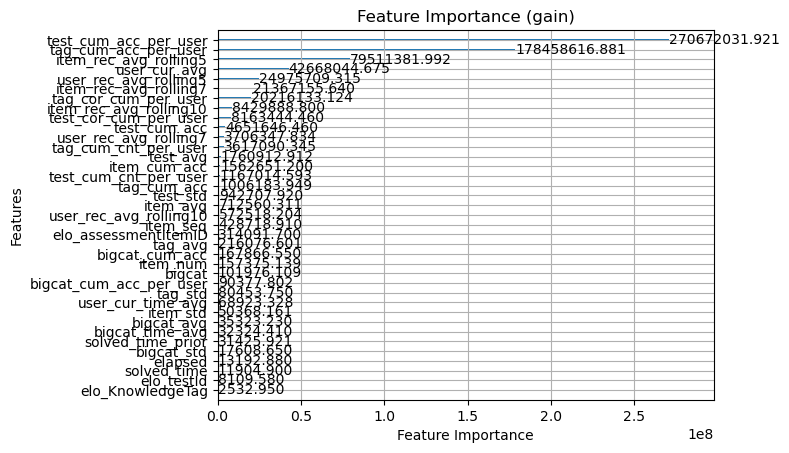

In [11]:
# model: 이미 학습이 완료된 LGBMModel, or Booster
# FEATURES: model 학습에 사용된 모든 features
# PATH: 그림을 저장할 경로

# SPLIT
ax = lgb.plot_importance(model, max_num_features=len(FEATS), importance_type='split')
ax.set(title=f'Feature Importance (split)',
	xlabel='Feature Importance',
	ylabel='Features')
ax.figure.savefig(f'./output/fi_split.png', dpi=300)


# GAIN
ax = lgb.plot_importance(model, max_num_features=len(FEATS), importance_type='gain')
ax.set(title=f'Feature Importance (gain)',
	xlabel='Feature Importance',
	ylabel='Features')
ax.figure.savefig(f'./output/fi_gain.png', dpi=300)